In [22]:
#Importação de bibliotecas
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide #para carregar os ficheiros .svs
import random
import os
import imageio.v2 as imageio

from PIL import Image
from tqdm import tqdm  # barra de progresso
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc as calc_auc, precision_recall_curve,  average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
import itertools
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,  GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)



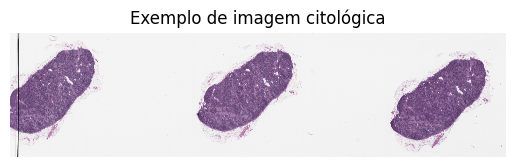

In [3]:
#carregar e visualizar as imagens 

# Caminho para a pasta onde estão os ficheiros .svs
image_folder = "/Volumes/TOSHIBA EXT/Trabalho final/SLN-Breast"
image_files = os.listdir(image_folder)

# Aumentar o limite de pixels para evitar o erro DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

#Carregar e mostrar uma imagem de exemplo
img_path = os.path.join(image_folder, image_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.title("Exemplo de imagem citológica")
plt.axis('off')
plt.show()

In [4]:
# Carregar dados suplementares
df = pd.read_csv("/Volumes/TOSHIBA EXT/Trabalho final/SLN-Breast/target.csv")

# Visualizar as primeiras linhas
print(df.head())

# Verificar distribuição das classes
print(df['target'].value_counts())

                     slide  target
0  HobI16-053768896760.svs       1
1  HobI16-072823783181.svs       1
2  HobI16-105105202254.svs       0
3  HobI16-303757967057.svs       0
4  HobI16-334188031493.svs       0
target
0    94
1    36
Name: count, dtype: int64


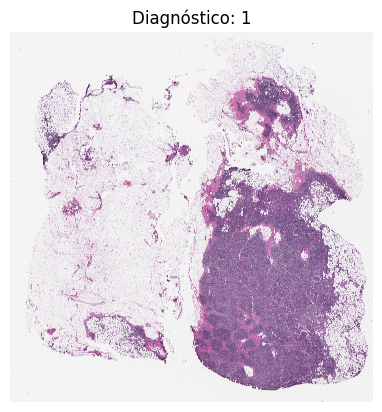

In [5]:
#Combinar as imagens com os dados do CSV
# Exemplo: carregar uma imagem com base no nome no CSV
sample = df.iloc[0]
img_path = os.path.join(image_folder, sample['slide'])
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Diagnóstico: {sample['target']}")
plt.axis('off')
plt.show()


[INFO] A extrair patches da classe 0...
[AVISO] Imagens acabaram antes de atingir 500 patches para a classe 0
[INFO] A extrair patches da classe 1...
[AVISO] Imagens acabaram antes de atingir 500 patches para a classe 1
[INFO] Distribuição final de patches por classe:
Classe 0: 450 patches
Classe 1: 392 patches


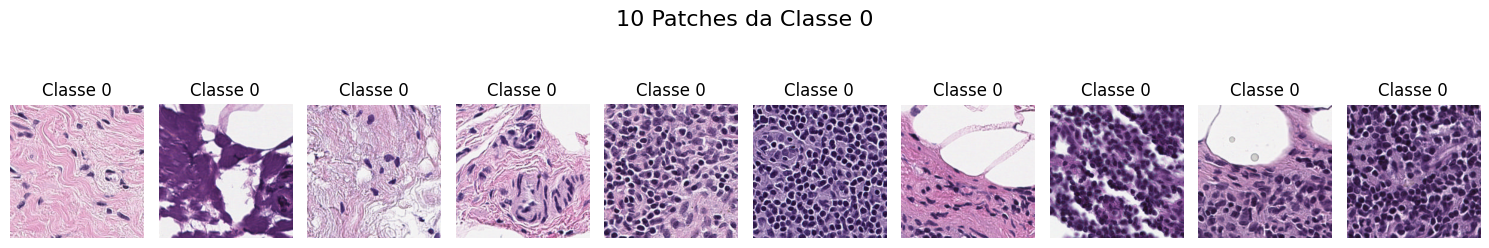

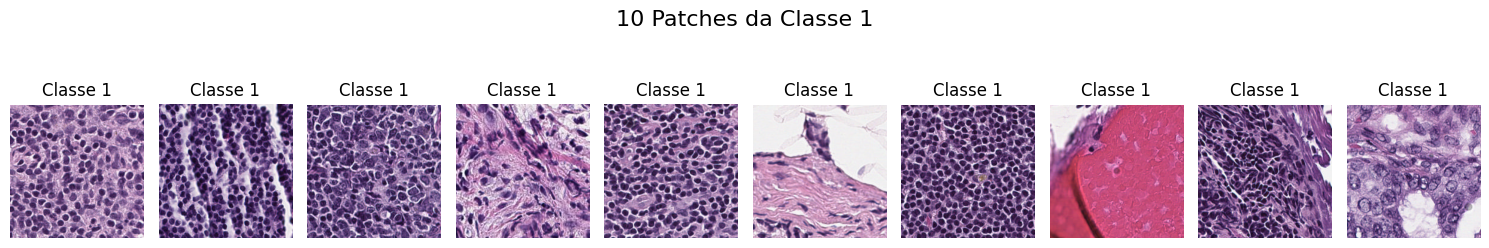

Total patches: 842 | Shape: (842, 224, 224, 3) | Class distribution: [450 392]


In [ ]:
# ---  Pré-processar cada imagem ---

patch_size = 224
n_patches_por_classe = 500 # número de patches por classe para ajudar a equilibrar o dataset
min_tissue_ratio = 0.6  # número de patches por imagem
min_informacao_threshold = 0.1  # patch médio mais escuro do que isto será ignorado
max_informacao_threshold = 0.9  # evita imagens quase brancas
data = []
counts_per_class = defaultdict(int)

# Agrupar imagens por classe para facilitar a extração balanceada
df_grouped = df.groupby('target')

# Vai  extrair patches para cada classe até atingir n_patches_por_classe
for classe, grupo in df_grouped:
    print(f"[INFO] A extrair patches da classe {classe}...")
    imagens_classe = grupo['slide'].tolist()
    random.shuffle(imagens_classe)
    
    idx_imagem = 0
    while counts_per_class[classe] < n_patches_por_classe:
        if idx_imagem >= len(imagens_classe):
            print(f"[AVISO] Imagens acabaram antes de atingir {n_patches_por_classe} patches para a classe {classe}")
            break
        
        file_path = os.path.join(image_folder, imagens_classe[idx_imagem])
        idx_imagem += 1
        
        try:
            slide = openslide.OpenSlide(file_path)
            slide_w, slide_h = slide.dimensions
            
            patches_collected = 0
            max_attempts = 100
            attempts = 0
            
            while patches_collected < n_patches_por_classe // len(imagens_classe) and attempts < max_attempts:
                x = random.randint(0, slide_w - patch_size)
                y = random.randint(0, slide_h - patch_size)
                
                patch = slide.read_region((x, y), 0, (patch_size, patch_size)).convert("RGB")
                patch_array = np.array(patch) / 255.0  # normalizado para [0, 1]
                
                tissue_ratio = (patch_array.mean(axis=2) < 0.9).mean()
                info_media = patch_array.mean()
                
                # Verifica se o patch tem tecido e não é escuro/danificado
                if tissue_ratio >= min_tissue_ratio and min_informacao_threshold <= info_media <= max_informacao_threshold:
                    data.append((patch_array, classe))
                    counts_per_class[classe] += 1
                    patches_collected += 1
                attempts += 1
                
        except Exception as e:
            print(f"[ERRO] {file_path}: {e}")

# --- Mostrar distribuição final ---
print("[INFO] Distribuição final de patches por classe:")
for classe, count in counts_per_class.items():
    print(f"Classe {classe}: {count} patches")

# --- Visualizar alguns patches por classe ---
def mostrar_patches_por_classe(data, n=5):
    """
    Mostra n patches aleatórios para cada classe presentes em 'data'.
    """
    classes = set(label for _, label in data)
    for classe in classes:
        patches_classe = [img for img, label in data if label == classe]
        amostras = random.sample(patches_classe, min(n, len(patches_classe)))
        
        plt.figure(figsize=(15, 3))
        for i, patch in enumerate(amostras):
            plt.subplot(1, n, i + 1)
            plt.imshow(patch)
            plt.title(f"Classe {classe}")
            plt.axis('off')
        plt.suptitle(f"{n} Patches da Classe {classe}", fontsize=16)
        plt.tight_layout()
        plt.show()

# Chamar a função para visualizar os patches
mostrar_patches_por_classe(data, n=10)

# Converter para arrays numpy
X = np.array([img for img, _ in data])
y = np.array([label for _, label in data])
print(f"Total patches: {len(X)} | Shape: {X.shape} | Class distribution: {np.bincount(y)}")


Counter({np.int64(0): 360, np.int64(1): 313}) Counter({np.int64(0): 90, np.int64(1): 79})
Imagens guardadas no treino: {'0': 358, '1': 312}
Imagens guardadas no teste: {'0': 90, '1': 79}
Imagens do conjunto de treino:


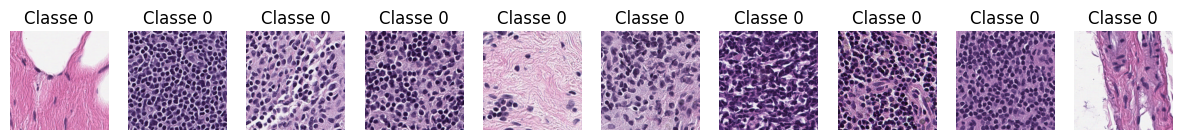

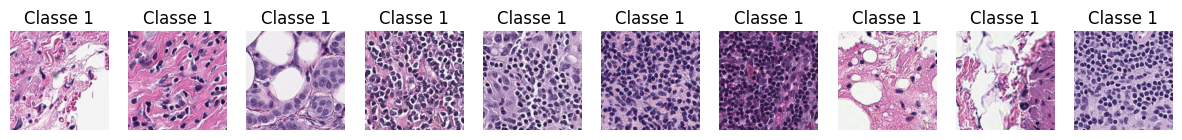

Imagens do conjunto de teste:


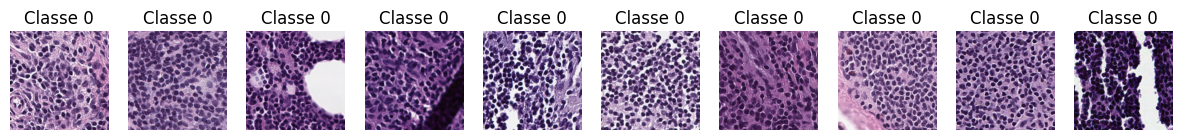

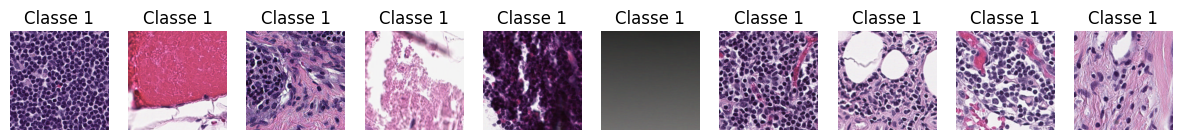

In [48]:
# --- Dividir e guardar patches em diretórios ---
base_dir = "/Volumes/TOSHIBA EXT/Trabalho final/PKG - SLN-Breast"
train_dir, test_dir = os.path.join(base_dir, "train"), os.path.join(base_dir, "test")
for d in [train_dir, test_dir]:
    for c in ["0", "1"]:
        os.makedirs(os.path.join(d, c), exist_ok=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

min_informacao_threshold = 0.20  # evitar imagens quase pretas
max_informacao_threshold = 0.85  # evitar imagens quase brancas

def save_patch(patch, label, split, index):
    """
    Guarda um patch se este tiver informação relevante (nem preto nem branco).
    Assume que os patches estão normalizados entre 0 e 1.
    """
    media_info = patch.mean()
    if not (min_informacao_threshold <= media_info <= max_informacao_threshold):
        return

    patch_uint8 = (patch * 255).astype(np.uint8)

    folder = train_dir if split == "train" else test_dir
    class_folder = os.path.join(folder, str(label))
    filename = f"{label}_{index}.png"
    imageio.imwrite(os.path.join(class_folder, filename), patch_uint8)

# Guardar os patches filtrados
for i, (img, label) in enumerate(zip(X_train, y_train)):
    save_patch(img, label, split="train", index=i)

for i, (img, label) in enumerate(zip(X_test, y_test)):
    save_patch(img, label, split="test", index=i)

print(Counter(y_train), Counter(y_test))

#Garantir que as imagens foram guardadas corretamente
def count_saved_images(directory):
    counts = {}
    for label in ["0", "1"]:
        folder = os.path.join(directory, label)
        counts[label] = len(os.listdir(folder))
    return counts

print("Imagens guardadas no treino:", count_saved_images(train_dir))
print("Imagens guardadas no teste:", count_saved_images(test_dir))

# Função para mostrar imagens aleatórias de cada classe
def show_random_images(directory, class_label, num_images=10):
    folder = os.path.join(directory, class_label)
    images = os.listdir(folder)
    selected_images = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images):
        img_path = os.path.join(folder, image_name)
        image = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Classe {class_label}")
        plt.axis('off')
    plt.show()

# Mostrar imagens do conjunto de treino
print("Imagens do conjunto de treino:")
show_random_images(train_dir, "0")
show_random_images(train_dir, "1")

# Mostrar imagens do conjunto de teste
print("Imagens do conjunto de teste:")
show_random_images(test_dir, "0")
show_random_images(test_dir, "1")


Found 670 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
Class weights: {0: np.float64(0.9357541899441341), 1: np.float64(1.0737179487179487)}


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


42/42 - 27s - 642ms/step - accuracy: 0.4970 - loss: 0.6982 - val_accuracy: 0.4675 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 2/10


42/42 - 18s - 434ms/step - accuracy: 0.4955 - loss: 0.6974 - val_accuracy: 0.5325 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 3/10


42/42 - 19s - 455ms/step - accuracy: 0.4970 - loss: 0.6952 - val_accuracy: 0.5325 - val_loss: 0.6915 - learning_rate: 1.0000e-04
Epoch 4/10
42/42 - 14s - 322ms/step - accuracy: 0.4866 - loss: 0.7002 - val_accuracy: 0.5325 - val_loss: 0.6919 - learning_rate: 1.0000e-04
Epoch 5/10


42/42 - 10s - 241ms/step - accuracy: 0.4851 - loss: 0.7024 - val_accuracy: 0.5325 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 6/10
42/42 - 11s - 263ms/step - accuracy: 0.4746 - loss: 0.6972 - val_accuracy: 0.5325 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 7/10
42/42 - 11s - 258ms/step - accuracy: 0.5328 - loss: 0.6951 - val_accuracy: 0.4675 - val_loss: 0.6958 - learning_rate: 1.0000e-04
Epoch 8/10
42/42 - 10s - 239ms/step - accuracy: 0.5090 - loss: 0.6941 - val_accuracy: 0.4675 - val_loss: 0.6985 - learning_rate: 1.0000e-04
Epoch 9/10
42/42 - 10s - 239ms/step - accuracy: 0.4612 - loss: 0.6985 - val_accuracy: 0.4793 - val_loss: 0.6943 - learning_rate: 2.0000e-05
Epoch 10/10
42/42 - 10s - 248ms/step - accuracy: 0.4821 - loss: 0.6955 - val_accuracy: 0.4675 - val_loss: 0.6949 - learning_rate: 2.0000e-05
Epoch 1/20
42/42 - 65s - 2s/step - accuracy: 0.4642 - auc_2: 0.4896 - loss: 0.7112 - val_accuracy: 0.4675 - val_auc_2: 0.5000 - val_loss: 0.6956 - learning_rate: 1.0000e-

42/42 - 52s - 1s/step - accuracy: 0.7313 - auc_2: 0.8051 - loss: 0.5934 - val_accuracy: 0.5680 - val_auc_2: 0.5620 - val_loss: 0.6881 - learning_rate: 1.0000e-05
Epoch 11/20


42/42 - 61s - 1s/step - accuracy: 0.7045 - auc_2: 0.8026 - loss: 0.5838 - val_accuracy: 0.5799 - val_auc_2: 0.6409 - val_loss: 0.6795 - learning_rate: 1.0000e-05
Epoch 12/20
42/42 - 1014s - 24s/step - accuracy: 0.7567 - auc_2: 0.8290 - loss: 0.5695 - val_accuracy: 0.5444 - val_auc_2: 0.6164 - val_loss: 0.6821 - learning_rate: 1.0000e-05
Epoch 13/20
42/42 - 50s - 1s/step - accuracy: 0.7642 - auc_2: 0.8349 - loss: 0.5567 - val_accuracy: 0.4734 - val_auc_2: 0.5216 - val_loss: 0.6981 - learning_rate: 1.0000e-05
Epoch 14/20
42/42 - 626s - 15s/step - accuracy: 0.7806 - auc_2: 0.8532 - loss: 0.5411 - val_accuracy: 0.4734 - val_auc_2: 0.5233 - val_loss: 0.6925 - learning_rate: 1.0000e-05
Epoch 15/20
42/42 - 45s - 1s/step - accuracy: 0.7582 - auc_2: 0.8574 - loss: 0.5319 - val_accuracy: 0.5680 - val_auc_2: 0.5617 - val_loss: 0.6858 - learning_rate: 2.0000e-06
Epoch 16/20
42/42 - 44s - 1s/step - accuracy: 0.7567 - auc_2: 0.8456 - loss: 0.5368 - val_accuracy: 0.5621 - val_auc_2: 0.5625 - val_loss

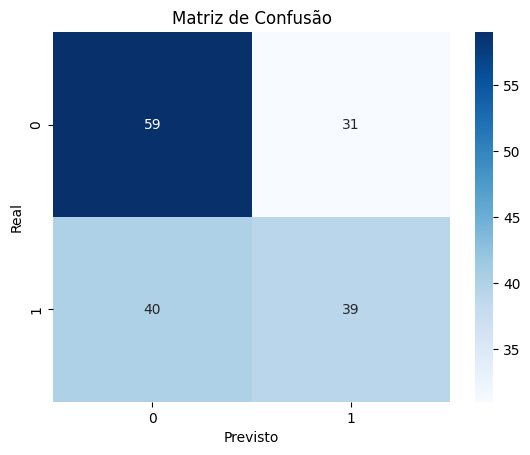

In [49]:
# --- Geradores de dados ---
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(rescale=1./255)  # Caso tenhas guardado sem normalizar

train_ds = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
test_ds = datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# --- Modelagem com EfficientNetB0 ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False # Congelar tudo inicialmente

# --- Cabeça do modelo ---
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=out)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Class weights ---
y_train_DL_labels = train_ds.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_DL_labels), y=y_train_DL_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


# --- Treinar modelo ---
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=3, factor=0.2),
    callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss')
]

# --- Treinar só a cabeça primeiro ---
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=cb,
    verbose=2
)

# --- Afinar a base do modelo (descongelar parcialmente) ---
base_model.trainable = True
for layer in base_model.layers:  # Descongelar todas as camadas
    layer.trainable = True

# Compilar novamente após alterações
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # LR menor
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Treino final com base descongelada parcialmente
history_fine = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=cb,
    verbose=2
)

# --- Avaliação com AUC e Matriz de Confusão ---
y_pred_proba = model.predict(test_ds)
y_pred = (y_pred_proba > 0.5).astype(int)
y_true = test_ds.classes

# AUC
auc = roc_auc_score(y_true, y_pred_proba)
print(f"\n✅ AUC final: {auc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.6453 - auc_2: 0.3908 - loss: 0.6763
Resultados da avaliação: [0.679460883140564, 0.5798816680908203, 0.6408579349517822]
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6453 - auc_2: 0.3908 - loss: 0.6763
Loss: 0.679 | Accuracy: 0.580 | AUC: 0.641
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
AUC-ROC: 0.638
Threshold ótimo: 0.488


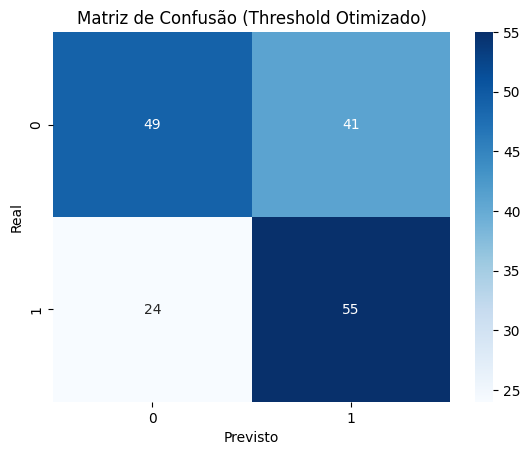

              precision    recall  f1-score   support

           0       0.67      0.54      0.60        90
           1       0.57      0.70      0.63        79

    accuracy                           0.62       169
   macro avg       0.62      0.62      0.61       169
weighted avg       0.63      0.62      0.61       169



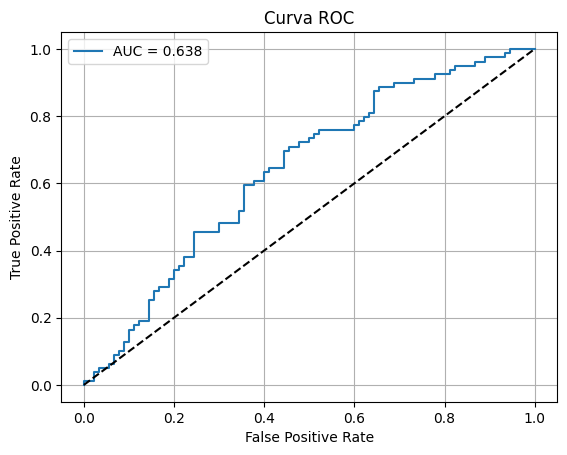

In [53]:
#Avaliação geral do modelo
results = model.evaluate(test_ds)
print(f"Resultados da avaliação: {results}")

loss, acc, auc = model.evaluate(test_ds)
print(f"Loss: {loss:.3f} | Accuracy: {acc:.3f} | AUC: {auc:.3f}")


# Extrair rótulos reais e previsões
y_true = test_ds.labels
y_probs = model.predict(test_ds).ravel()


# AUC-ROC
auc_score = roc_auc_score(y_true, y_probs)
print(f"AUC-ROC: {auc_score:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold ótimo: {optimal_threshold:.3f}")

# Previsões com threshold otimizado
y_pred_opt = (y_probs > optimal_threshold).astype(int)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Threshold Otimizado)")
plt.show()

# Relatório de classificação
class_names = ['0', '1']
print(classification_report(y_true, y_pred_opt, target_names=class_names))

# Curva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()